File 1: giongdanong\Ha_1888.wav, Similarity: 0.0028887490662270737
File 2: giongdanong\Ha_1058.wav, Similarity: 0.0027647303079886315
File 3: giongdanong\Ha_162.wav, Similarity: 0.002698292219073791
Visualizing features for the input file:


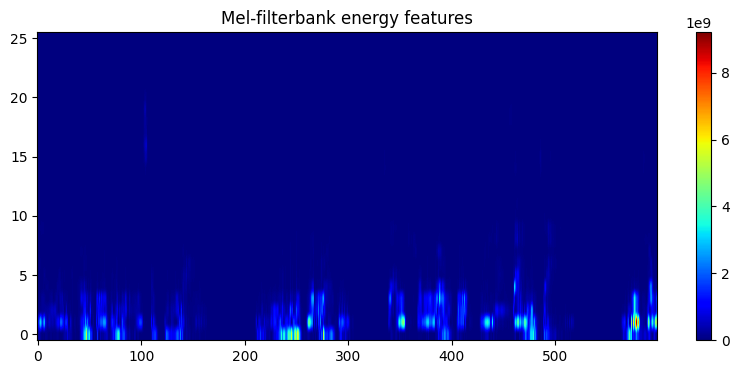

C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\matplotlib\axes\_axes.py:7939: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


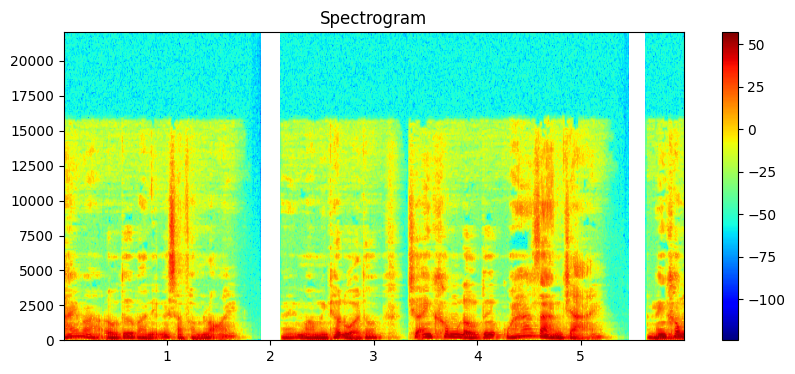

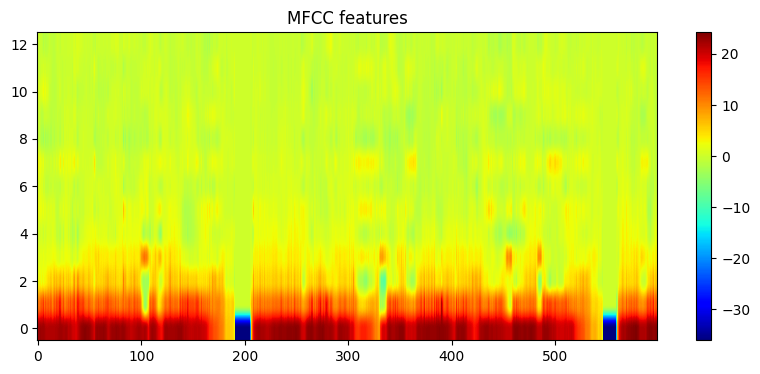

Visualizing features for file 1: giongdanong\Ha_1888.wav


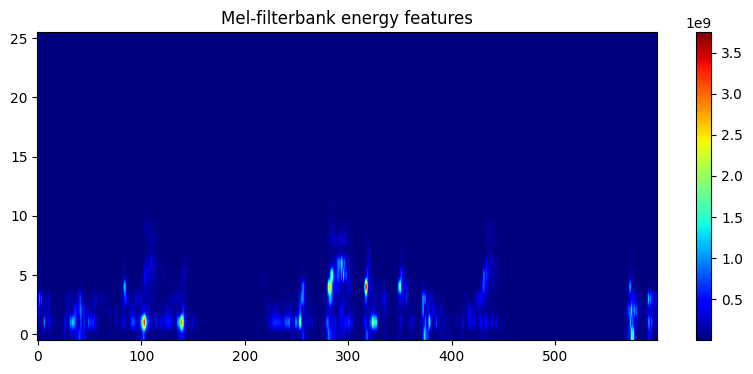

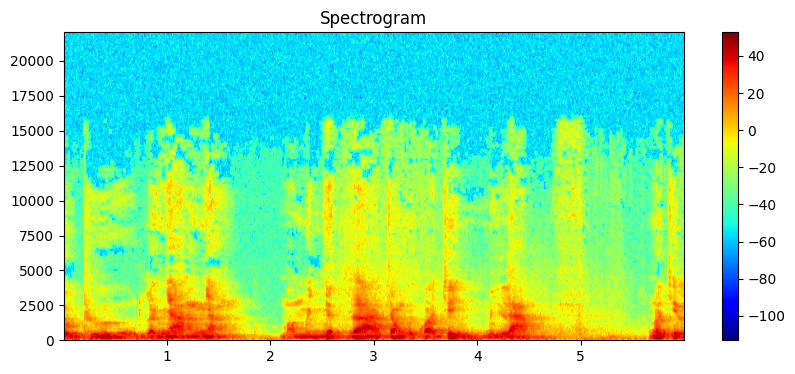

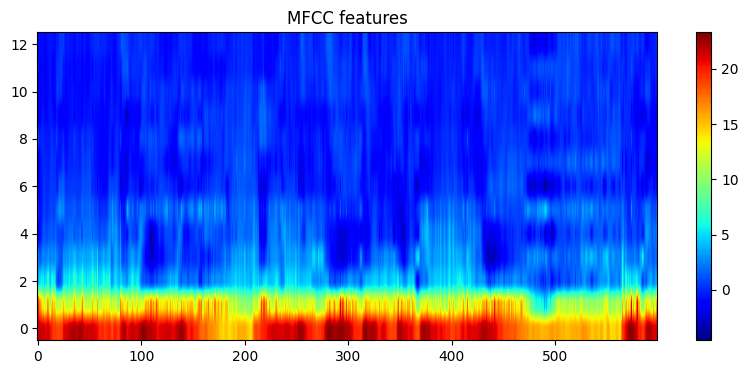

Visualizing features for file 2: giongdanong\Ha_1058.wav


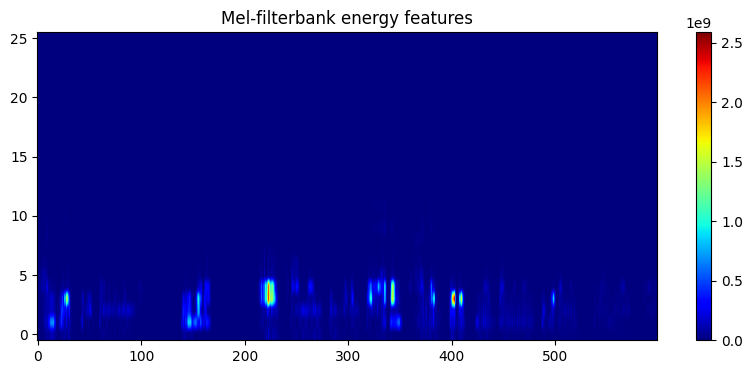

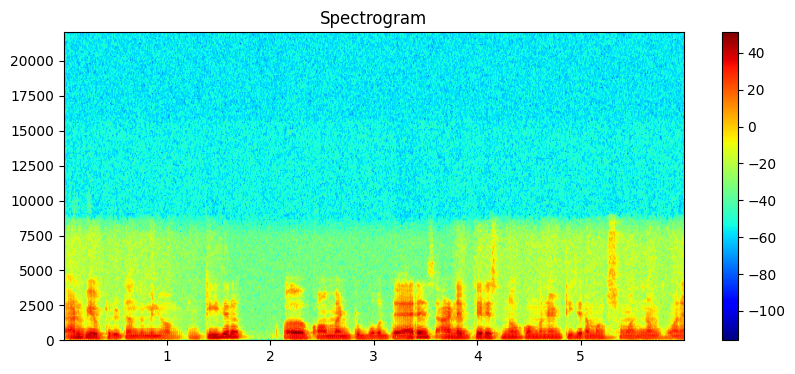

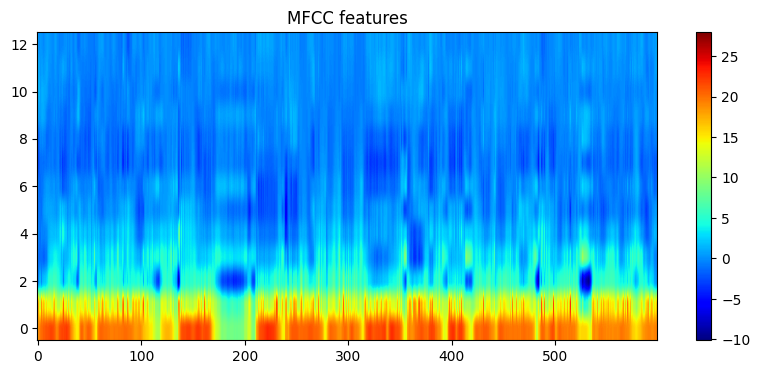

Visualizing features for file 3: giongdanong\Ha_162.wav


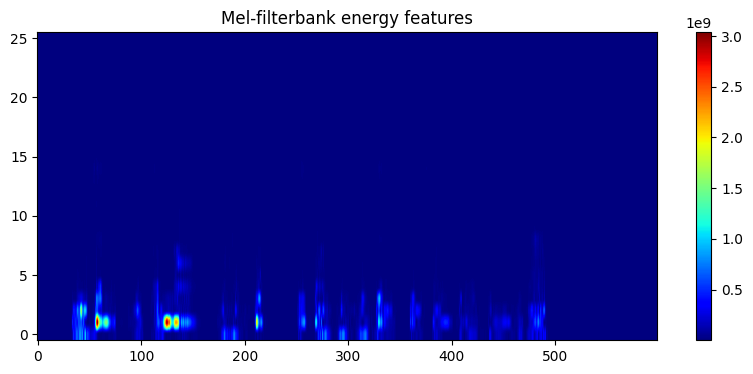

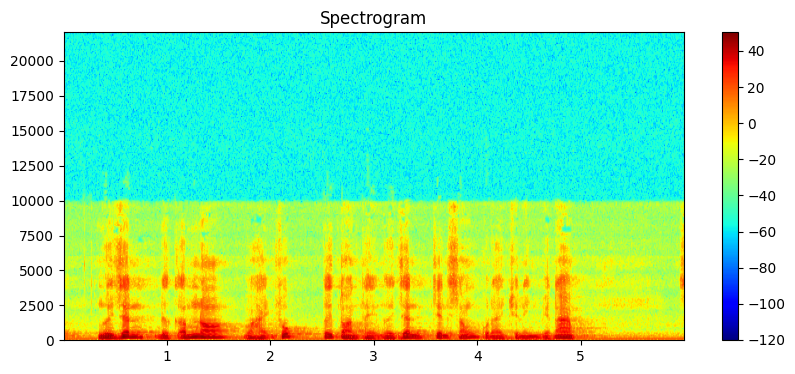

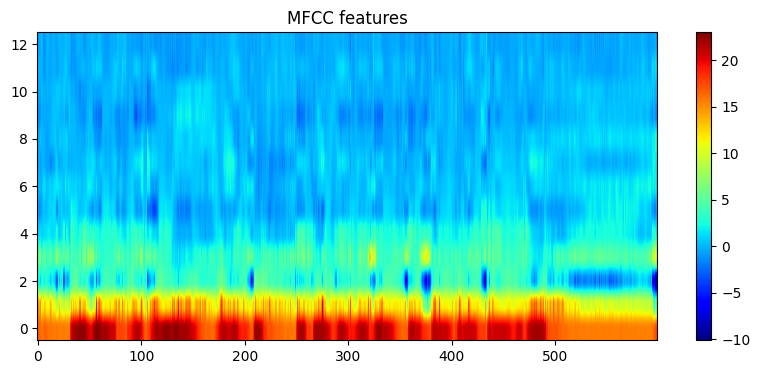

In [1]:
import numpy as np
import scipy.io.wavfile as wav
import os
import pandas as pd
import matplotlib.pyplot as plt

def calculate_nfft(samplerate, winlen):
    """Calculates the FFT size as a power of two greater than or equal to
    the number of samples in a single window length.
    """
    window_length_samples = winlen * samplerate
    nfft = 1
    while nfft < window_length_samples:
        nfft *= 2
    return nfft
def dct_custom(x, type=2, axis=-1, norm=None):
    """Compute the Discrete Cosine Transform (DCT) of type II manually."""
    if type != 2:
        raise ValueError("Currently, only DCT type II is supported.")
    
    # Move the axis to be transformed to the last position
    x = np.moveaxis(x, axis, -1)
    N = x.shape[-1]  # Length of the axis to transform
    factor = np.sqrt(2 / N) if norm == 'ortho' else 1  # Determine the normalization factor

    # Initialize the output array
    X = np.zeros_like(x)

    # Compute DCT-II along the last axis
    for k in range(N):
        sum_val = np.zeros_like(x[..., 0])
        for n in range(N):
            sum_val += x[..., n] * np.cos(np.pi * (n + 0.5) * k / N)
        
        if norm == 'ortho' and k == 0:
            X[..., k] = sum_val * np.sqrt(1 / N)
        else:
            X[..., k] = sum_val * factor

    # Move the transformed axis back to its original position
    X = np.moveaxis(X, -1, axis)
    
    return X


def mfcc(signal, samplerate=44100, winlen=0.025, winstep=0.01, numcep=13,
         nfilt=26, nfft=None, lowfreq=0, highfreq=None, appendEnergy=True,
         winfunc=lambda x: np.ones((x,))):
    """Compute MFCC features from an audio signal."""
    nfft = nfft or calculate_nfft(samplerate, winlen)
    feat, energy = fbank(signal, samplerate, winlen, winstep, nfilt, nfft, lowfreq, highfreq, winfunc)
    feat = np.log(feat)
    feat = dct_custom(feat, type=2, axis=1, norm='ortho')[:, :numcep]
    if appendEnergy:
        feat[:, 0] = np.log(energy)  # replace first cepstral coefficient with log of frame energy
    return feat

def fbank(signal, samplerate=44100, winlen=0.025, winstep=0.01,
          nfilt=26, nfft=512, lowfreq=0, highfreq=None,
          winfunc=lambda x: np.ones((x,))):
    """Compute Mel-filterbank energy features from an audio signal."""
    highfreq = highfreq or samplerate / 2
    frames = framesig(signal, winlen * samplerate, winstep * samplerate, winfunc)
    pspec = powspec(frames, nfft)
    energy = np.sum(pspec, 1)  # this stores the total energy in each frame
    energy = np.where(energy == 0, np.finfo(float).eps, energy)  # if energy is zero, we get problems with log

    fb = get_filterbanks(nfilt, nfft, samplerate, lowfreq, highfreq)
    feat = np.dot(pspec, fb.T)  # compute the filterbank energies
    feat = np.where(feat == 0, np.finfo(float).eps, feat)  # if feat is zero, we get problems with log

    return feat, energy

def logfbank(signal, samplerate=44100, winlen=0.025, winstep=0.01,
             nfilt=26, nfft=512, lowfreq=0, highfreq=None,
             winfunc=lambda x: np.ones((x,))):
    """Compute log Mel-filterbank energy features from an audio signal."""
    feat, energy = fbank(signal, samplerate, winlen, winstep, nfilt, nfft, lowfreq, highfreq, winfunc)
    return np.log(feat)

def hz2mel(hz):
    return 2595 * np.log10(1 + hz / 700.)

def mel2hz(mel):
    return 700 * (10 ** (mel / 2595.0) - 1)

def get_filterbanks(nfilt=20, nfft=512, samplerate=44100, lowfreq=0, highfreq=None):
    """Compute a Mel-filterbank."""
    highfreq = highfreq or samplerate / 2
    assert highfreq <= samplerate / 2, "highfreq is greater than samplerate/2"

    # compute points evenly spaced in mels
    lowmel = hz2mel(lowfreq)
    highmel = hz2mel(highfreq)
    melpoints = np.linspace(lowmel, highmel, nfilt + 2)
    # our points are in Hz, but we use fft bins, so we have to convert
    # from Hz to fft bin number
    bin = np.floor((nfft + 1) * mel2hz(melpoints) / samplerate)

    fbank = np.zeros([nfilt, nfft // 2 + 1])
    for j in range(0, nfilt):
        for i in range(int(bin[j]), int(bin[j + 1])):
            fbank[j, i] = (i - bin[j]) / (bin[j + 1] - bin[j])
        for i in range(int(bin[j + 1]), int(bin[j + 2])):
            fbank[j, i] = (bin[j + 2] - i) / (bin[j + 2] - bin[j + 1])
    return fbank

# Additional functions for frame and power spectrum calculations
def framesig(sig, frame_len, frame_step, winfunc=lambda x: np.ones((x,)), stride_trick=True):
    """Frame a signal into overlapping frames."""
    slen = len(sig)
    frame_len = int(round(frame_len))
    frame_step = int(round(frame_step))
    numframes = 1 + int(np.ceil((1.0 * slen - frame_len) / frame_step))
    
    padlen = int((numframes - 1) * frame_step + frame_len)
    zeros = np.zeros((padlen - slen,))
    padsignal = np.concatenate((sig, zeros))

    if stride_trick:
        win = winfunc(frame_len)
        frames = np.lib.stride_tricks.as_strided(
            padsignal, shape=(numframes, frame_len), strides=(padsignal.strides[0] * frame_step, padsignal.strides[0])
        ).copy()
        return frames * win
    else:
        indices = np.tile(np.arange(0, frame_len), (numframes, 1)) + np.tile(
            np.arange(0, numframes * frame_step, frame_step), (frame_len, 1)
        ).T
        indices = np.array(indices, dtype=np.int32)
        frames = padsignal[indices]
        return frames * winfunc(frame_len)

def powspec(frames, NFFT):
    """Compute the power spectrum of each frame."""
    return 1.0 / NFFT * np.square(np.abs(np.fft.rfft(frames, NFFT)))

# # Example usage:
# rate, sig = wav.read("Tham_2008.wav")
# if sig.ndim > 1:
#     sig = sig[:, 0]  # Use the first channel if the signal is stereo
# features = mfcc(sig, samplerate=rate)
# print(features)

def extract_features(audio_files):
    features_list = []
    for file in audio_files:
        rate, sig = wav.read(file)
        if sig.ndim > 1:
            sig = sig[:, 0]
        mfcc_feat = mfcc(sig, samplerate=rate)
        features_list.append((file, mfcc_feat.tolist()))
    return features_list

def save_mfcc_to_csv(features_list, output_file):
    df = pd.DataFrame(features_list, columns=['File', 'MFCC'])
    df.to_csv(output_file, index=False)

# Directory containing audio files
data_dir = 'giongdanong'
audio_files = [os.path.join(data_dir, file) for file in os.listdir(data_dir)]
features_list = extract_features(audio_files)
output_file = 'mfcc_features.csv'
if os.path.exists(output_file):
    os.remove(output_file)
save_mfcc_to_csv(features_list, output_file)

def calculate_similarity(mfcc1, mfcc2):
    distance = np.linalg.norm(mfcc1 - mfcc2)
    similarity = 1 / (1 + distance)
    return similarity

def find_most_similar_files(input_file, audio_files):
    rate, input_sig = wav.read(input_file)
    if input_sig.ndim > 1:
        input_sig = input_sig[:, 0]
    input_mfcc = mfcc(input_sig, samplerate=rate)
    
    similarities = []
    for file in audio_files:
        rate, sig = wav.read(file)
        if sig.ndim > 1:
            sig = sig[:, 0]
        mfcc_feat = mfcc(sig, samplerate=rate)
        similarity = calculate_similarity(input_mfcc, mfcc_feat)
        similarities.append((file, similarity))
    
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:3]

input_file = 'input/Tham_2008.wav'
audio_files = [os.path.join(data_dir, file) for file in os.listdir(data_dir)]
top_similar_files = find_most_similar_files(input_file, audio_files)
for idx, (file, similarity) in enumerate(top_similar_files):
    print(f"File {idx+1}: {file}, Similarity: {similarity}")

def visualize_features(audio_file):
    rate, sig = wav.read(audio_file)
    if sig.ndim > 1:
        sig = sig[:, 0]

    # Plot Mel-filterbank energies
    mel_feat, _ = fbank(sig, samplerate=rate)
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_feat.T, origin='lower', aspect='auto', cmap='jet')
    plt.title('Mel-filterbank energy features')
    plt.colorbar()
    plt.show()

    # Plot Spectrogram
    plt.figure(figsize=(10, 4))
    plt.specgram(sig, NFFT=512, Fs=rate, noverlap=256, cmap='jet')
    plt.title('Spectrogram')
    plt.colorbar()
    plt.show()

    # Plot MFCC features
    mfcc_feat = mfcc(sig, samplerate=rate)
    plt.figure(figsize=(10, 4))
    plt.imshow(mfcc_feat.T, origin='lower', aspect='auto', cmap='jet')
    plt.title('MFCC features')
    plt.colorbar()
    plt.show()

# Visualize features for the input file
print("Visualizing features for the input file:")
visualize_features(input_file)

# Visualize features for the top 3 similar files
for idx, (file, _) in enumerate(top_similar_files):
    print(f"Visualizing features for file {idx+1}: {file}")
    visualize_features(file)
